# Calibration of the Optimal Steps Model

This script is an attempt to recompute the results in silver-2016b page 51. The scenario [scenario](./../../../../VadereModelTests/TestOSM_calibration/rimea_04_calibration_osm.scenario) is based on the RiMEA-Test 4. We use the `Teleporter` to model a circular scenario and the parameter `useFreeSpaceOnly = false` to generate high densities. The following code plots all the necessary diagrams.

In [387]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vadere_analysis_tool import ScenarioOutput, VadereProject
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.0})

def plotEvolution(vproject, ending, yval, ylabel):
    plots = []
    i = 1
    plt.figure(1, figsize=(30, 10))
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        dataFrames = []
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                #df = df[df.velocity > 0]
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['timeStep'] = df.timeStep.astype(int)
                ndf['scenario'] = [out.scenario['name']] * len(df.density)
                dataFrames.append(ndf)
            #concatFrames = pd.concat(dataFrames)
        plt.subplot(2, 1, i)
        plt.title(out.scenario['name'])
        plt.xlabel('timeStep')
        plt.ylabel(ylabel)
        sns.lineplot(x='timeStep', y=yval, data=pd.concat(dataFrames))
        i = i + 1

def plotFundamentalDiagram(vproject, ending):
    dataFrames = []
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                dataFrames.append(ndf)
    concatFrames = pd.concat(dataFrames)
    g = sns.relplot(x="density", y="velocity", hue="scenario", data=concatFrames,
                height=10, aspect=2)
    
def plotFundamentalDiagramScatter(vproject, ending):
    dataFrames = []
    count = 1
    f = plt.figure(1, figsize=(20, 5))
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                #plt.scatter()
                plt.subplot((140+count))
                plt.title(out.scenario['name'])
                plt.xlabel('density')
                plt.ylabel('velocity')
                plt.legend(['A simple line'])
                plt.xticks([0,1,2,3,4,5,6])
                plt.yticks([0,0.5,1,1.5,2,2.5])
                plt.xlim(0,6)
                plt.ylim(0,2.5)
                fd = plt.scatter('density', 'velocity', data=ndf, marker='*', c='black', s=0.5)
                wm = plotWeidmann()
                plt.legend([fd, wm], ['Simulated data', 'Referenz Weidmann'])
                count = count + 1;
        f.savefig("./"+ending+".pdf", bbox_inches='tight')


In [284]:
def plotWeidmann():
    wmaxDensity = 5.4
    wmeanVelocity = 1.34
    wgamma = 1.913
    wx = np.linspace(0.1, wmaxDensity, 100)
    return plotKladek(wx, wmeanVelocity, wgamma, wmaxDensity)

def plotKladek(x, v, gamma, pmax):
    result, = plt.plot(x, v * (1 - np.exp(-gamma * (1/x - 1/pmax))), c=sns.color_palette().as_hex()[1])
    return result

First we load the project

In [393]:
projectFolder = "./../../../../VadereModelTests/TestOSM_calibration/"
project = VadereProject(projectFolder)
#out = project.named_output.C_050_180_180_2018_11_26_16_30_29_355()

loaded 4 out of 4 output directories. 


# Meassurement methods
All methods are described in zhang-2011.

## Method A Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

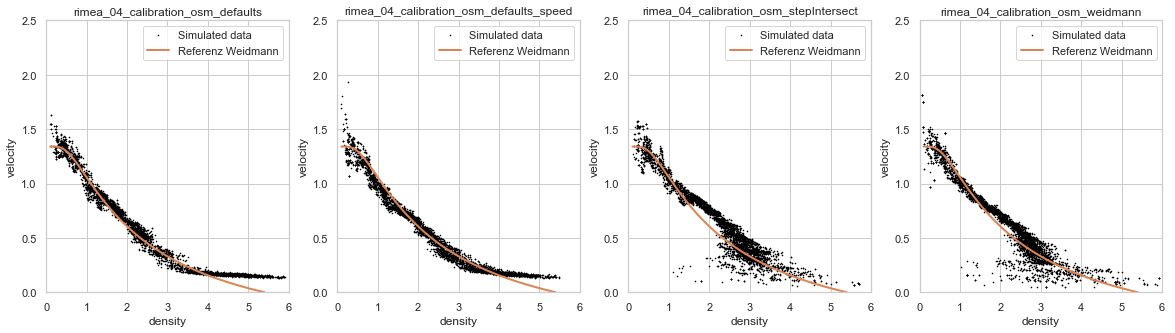

In [394]:
# transform data frame
plotFundamentalDiagramScatter(project, "aTimeStep.fundamentalDiagram")

## Method B Plots
This method does not work for this scenario since agents run multiple times through the same measurement area.

## Method C Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

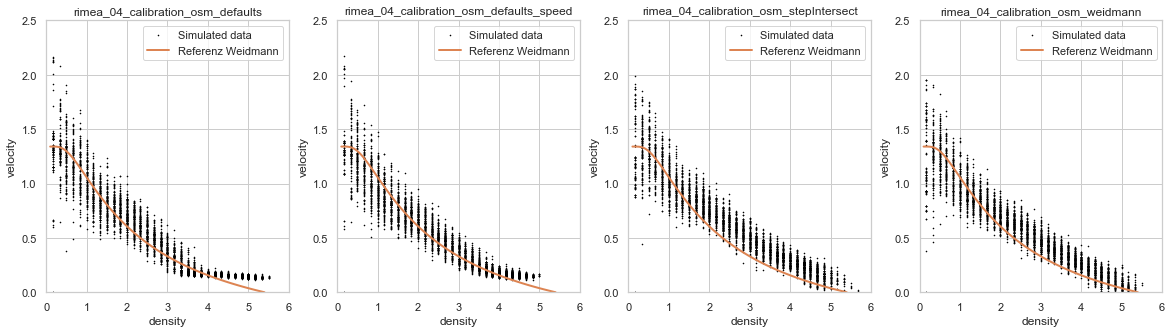

In [395]:
plotFundamentalDiagramScatter(project, "cTimeStep.fundamentalDiagram")

## Method D Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

In [396]:
plotFundamentalDiagramScatter(project, "dTimeStep.fundamentalDiagram")

FileNotFoundError: File b'./../../../../VadereModelTests/TestOSM_calibration/output/rimea_04_calibration_osm_defaults_2018-12-11_10-25-56.681/dTimeStep.fundamentalDiagram' does not exist

## Method E Plots
This method is similar to method D but the density is defined by $$\langle \rho \rangle = \frac{1}{N} \sum\limits_{i=1}^{N} A_i ,$$
and the velocity is defined by 
$$\langle v \rangle = \sum\limits_{i=1}^{N} \frac{1}{A_i} \left( \sum\limits_{i=1}^{N} A_i v_i(t) \right) ,$$

where $N$ is the number of pedestrians inside the measurement area and $A_i$ is the area of the voronoi cell of agent $i$.

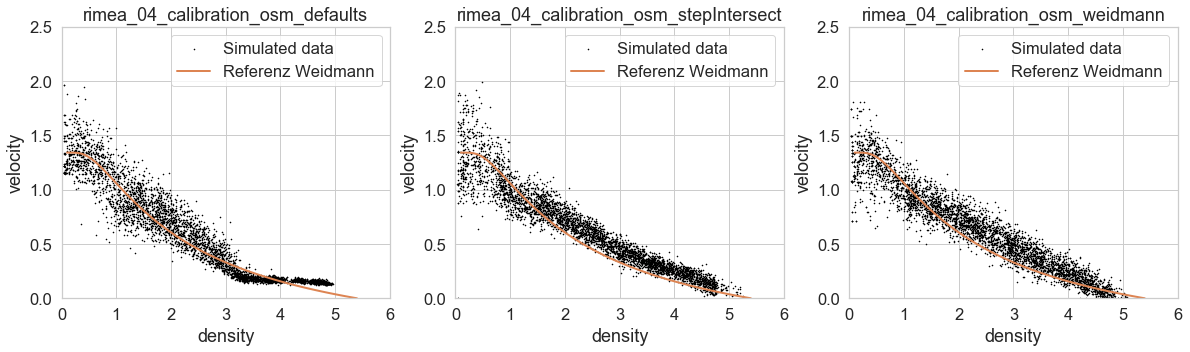

In [379]:
plotFundamentalDiagramScatter(project, "eTimeStep.fundamentalDiagram")

## Density and velocity evolution

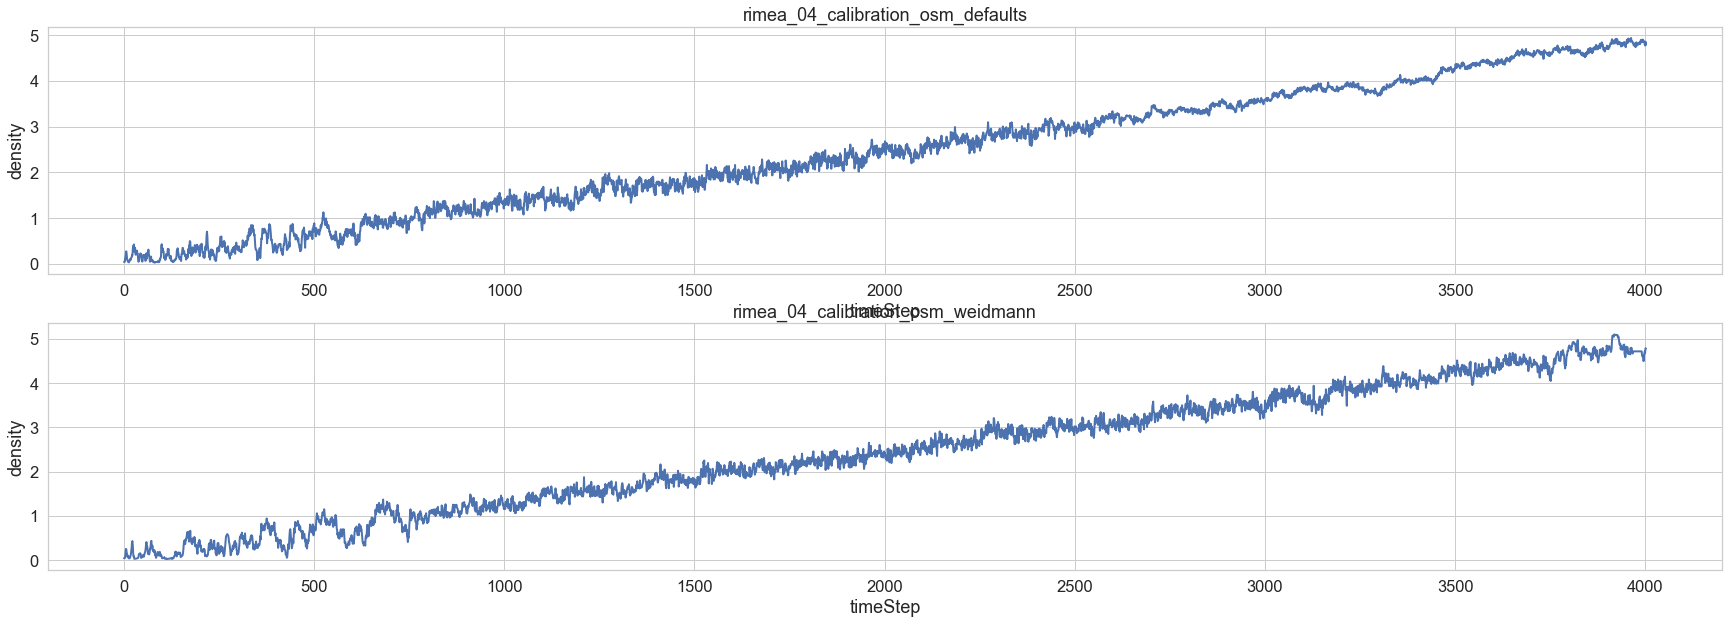

In [354]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "density", "density")
#plotEvolution(project, "aTimeStep.fundamentalDiagram", "density", "density")

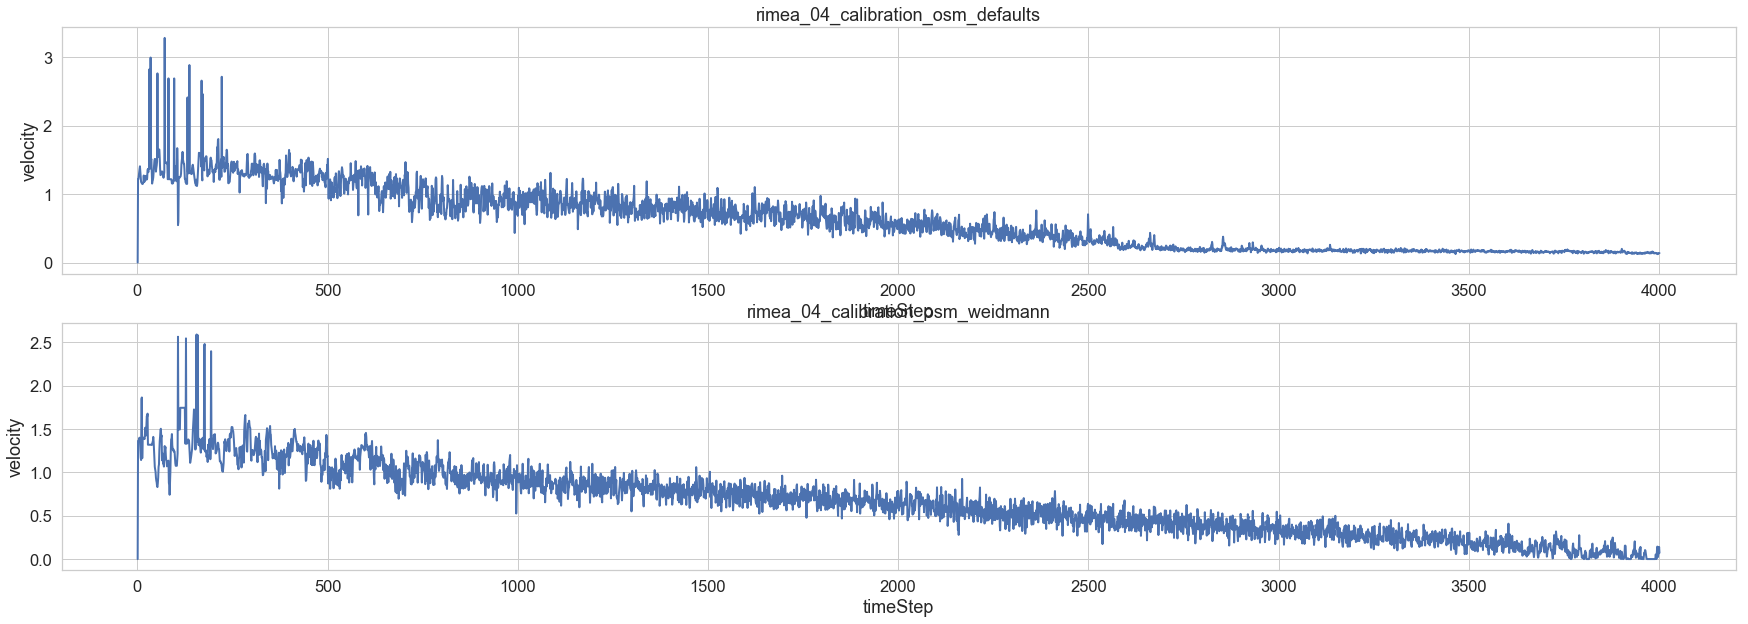

In [358]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "velocity", "velocity")